# Running the DAG in your notebook

This notebook uses the existing module definitions to build the DAG and run it in this notebook.

In [3]:
from components import feature_transforms, iris_loader, models
from hamilton_sdk import adapters

from hamilton import driver as h_driver
from hamilton.io.materialization import to
from hamilton.lifecycle import PrintLnHook

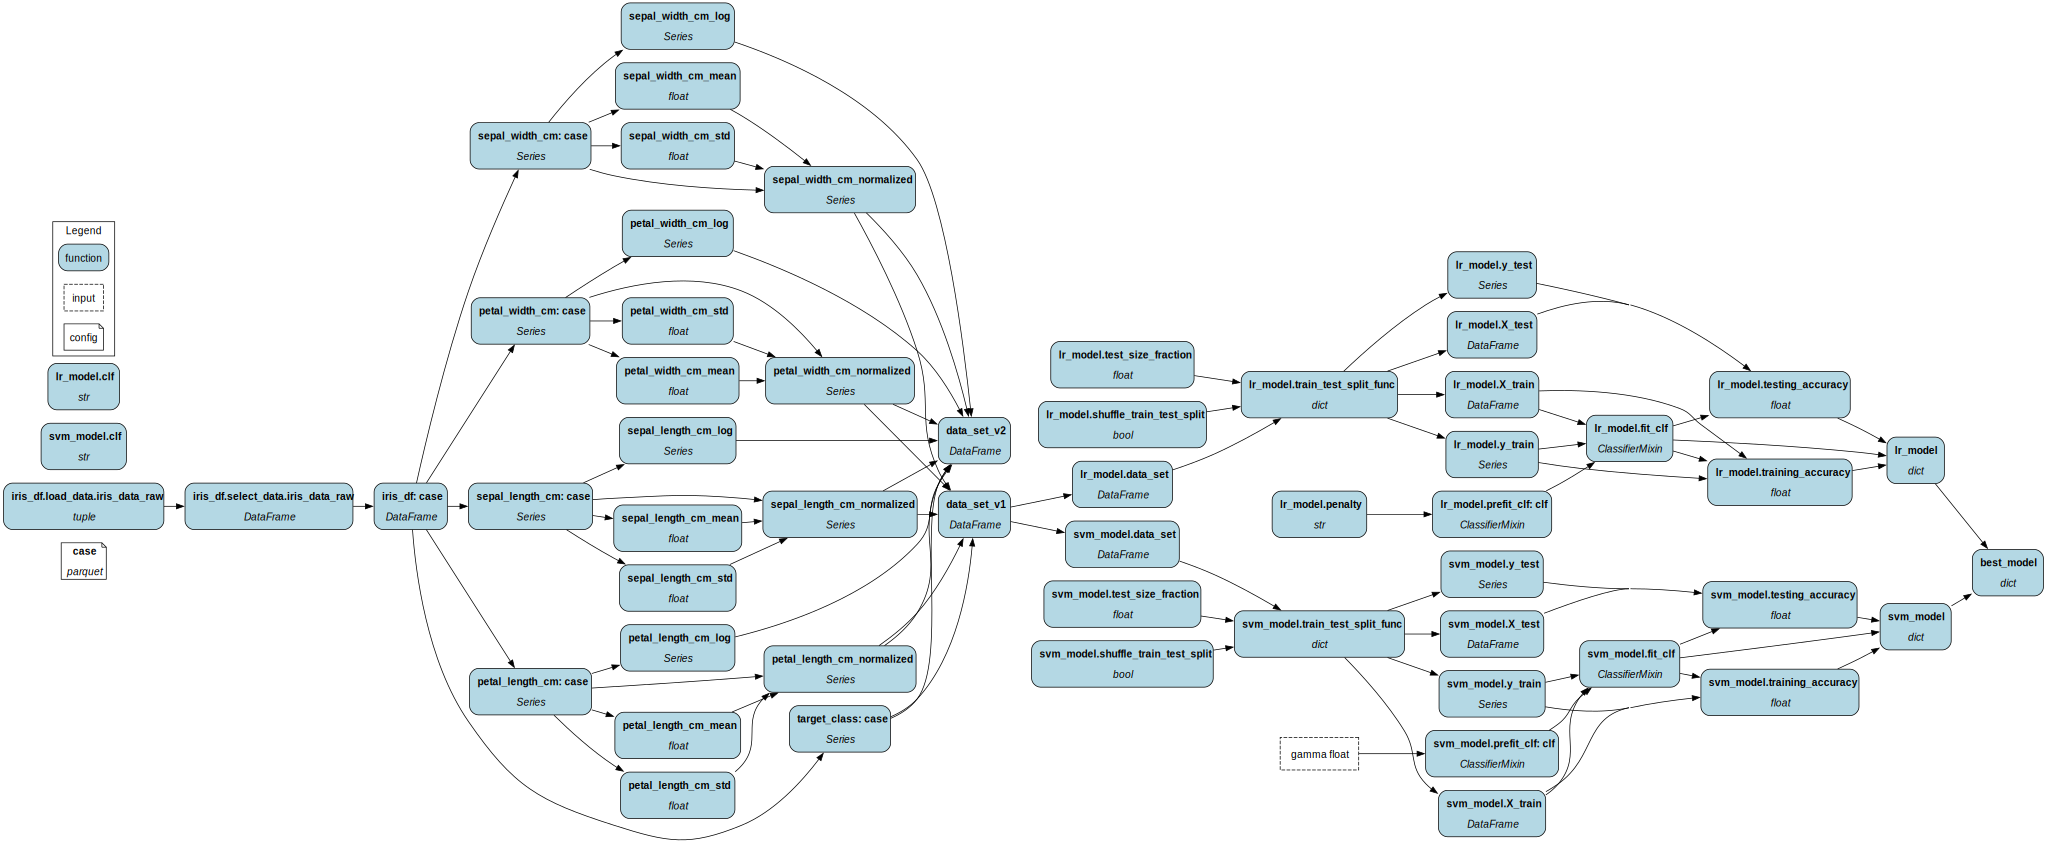

In [2]:
# set up config and inputs
config = {"case": "parquet"}
dag_name = "machine_learning_dag"
email = "elijah@dagworks.io"  # your email
project_id = 38 # your project id

# create tracker object
tracker = adapters.HamiltonTracker(
    username=email,
    project_id=project_id,
    dag_name=dag_name,
    tags={
        "template": "machine_learning",
        "loading_data_from": "parquet",
        "TODO": "add_more_tags_to_find_your_run_later",
    },
)
# create the driver object
dr = (
    h_driver.Builder()
    .with_config(config)  # this shapes the DAG
    .with_modules(iris_loader, feature_transforms, models)
    .with_adapters(tracker, PrintLnHook(verbosity=1))
    .build()
)
dr

In [7]:
# set up what inputs and outputs we want
inputs = {}
outputs_to_materialize = [
    to.parquet(
            id="data_set_v1_saver",
            path="data_set_v1.parquet",
            dependencies=["data_set_v1"],
        ),
    to.pickle(
        id="svm_model_saver",
        path="svm_model.pkl",
        dependencies=["svm_model"],
    ),
    to.pickle(
        id="lr_model_saver",
        path="lr_model.pkl",
        dependencies=["lr_model"],
    )
]

In [8]:
# execute the DAG and materialize a few things from it
metadata, result = dr.materialize(
    # This approach helps centralize & standardize how objects are read/written and also how metadata
    # about them is captured. This is useful for tracking lineage and provenance.
    *outputs_to_materialize,
    additional_vars=["best_model"],
    inputs=inputs,
)


Capturing execution run. Results can be found at http://localhost:8242/dashboard/project/38/runs/85



Executing node: svm_model.prefit_clf.
Finished debugging node: svm_model.prefit_clf in 398μs. Status: Success.
Executing node: iris_df.load_data.iris_data_raw.
Finished debugging node: iris_df.load_data.iris_data_raw in 5.8ms. Status: Success.
Executing node: iris_df.select_data.iris_data_raw.
Finished debugging node: iris_df.select_data.iris_data_raw in 63.4ms. Status: Success.
Executing node: iris_df.
Finished debugging node: iris_df in 71ms. Status: Success.
Executing node: sepal_length_cm.
Finished debugging node: sepal_length_cm in 16.5ms. Status: Success.
Executing node: sepal_length_cm_mean.
Finished debugging node: sepal_length_cm_mean in 253μs. Status: Success.
Executing node: sepal_length_cm_std.
Finished debugging node: sepal_length_cm_std in 258μs. Status: Success.
Executing node: sepal_length_cm_normalized.
Finished debugging node: sepal_length_cm_normalized in 17.7ms. Status: Success.
Executing node: sepal_width_cm.
Finished debugging node: sepal_width_cm in 18.2ms. Statu


Captured execution run. Results can be found at http://localhost:8242/dashboard/project/38/runs/85



Finished debugging node: lr_model.X_test in 25.7ms. Status: Success.
Executing node: lr_model.y_test.
Finished debugging node: lr_model.y_test in 1.61ms. Status: Success.
Executing node: lr_model.testing_accuracy.
Finished debugging node: lr_model.testing_accuracy in 1.64ms. Status: Success.
Executing node: lr_model.
Finished debugging node: lr_model in 340μs. Status: Success.
Executing node: best_model.
Finished debugging node: best_model in 290μs. Status: Success.
Executing node: data_set_v1_saver.
Finished debugging node: data_set_v1_saver in 5.22ms. Status: Success.
Executing node: svm_model_saver.
Finished debugging node: svm_model_saver in 589μs. Status: Success.
Executing node: lr_model_saver.
Finished debugging node: lr_model_saver in 387μs. Status: Success.


In [9]:
metadata

{'data_set_v1_saver': {'file_metadata': {'size': 6386,
   'path': 'data_set_v1.parquet',
   'last_modified': 1716833143.4420505,
   'timestamp': 1716858343.44226,
   'scheme': '',
   'notes': ''},
  'dataframe_metadata': {'rows': 150,
   'columns': 5,
   'column_names': ['sepal_length_cm_normalized',
    'sepal_width_cm_normalized',
    'petal_length_cm_normalized',
    'petal_width_cm_normalized',
    'target_class'],
   'datatypes': ['float64', 'float64', 'float64', 'float64', 'object']}},
 'svm_model_saver': {'file_metadata': {'size': 7697,
   'path': 'svm_model.pkl',
   'last_modified': 1716833143.4430761,
   'timestamp': 1716858343.443196,
   'scheme': '',
   'notes': ''}},
 'lr_model_saver': {'file_metadata': {'size': 1109,
   'path': 'lr_model.pkl',
   'last_modified': 1716833143.4436038,
   'timestamp': 1716858343.443672,
   'scheme': '',
   'notes': ''}}}

In [10]:
result

{'best_model': {'logistic': LogisticRegression(),
  'training_accuracy': 0.95,
  'testing_accuracy': 0.9666666666666667}}